<a href="https://colab.research.google.com/github/jadechip/on-chain-analytics-lstm/blob/master/metrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import io
import json
import requests
import functools
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None

## Bitcoin price

In [0]:
def make_request(url, *args):
  print(url(*args))
  return requests.get(url(*args))

In [0]:
start      = 20100718
end        = 20180429
params     = "PriceUSD"
url        = lambda params: f"https://community-api.coinmetrics.io/v2/assets/btc/metricdata?metrics={params}&start={start}&end={end}"

In [4]:
response = make_request(url, "PriceUSD")

https://community-api.coinmetrics.io/v2/assets/btc/metricdata?metrics=PriceUSD&start=20100718&end=20180429


In [0]:
json = response.json()

In [0]:
price_df = pd.DataFrame(json["metricData"]["series"])
price_df["values"] = price_df["values"].apply(lambda x: x[0])
price_df["values"] = price_df["values"].astype(float)

In [0]:
price_df['time'] = pd.to_datetime(price_df['time'])
price_df['time'] = price_df['time'].dt.strftime('%d-%m-%Y')

In [8]:
price_df.head()

,time,values
0,18-07-2010,0.085840
1,19-07-2010,0.080800
2,20-07-2010,0.074736
3,21-07-2010,0.079193
4,22-07-2010,0.058470


## Metrics

In [0]:
start      = 1279324800
end        = 1524960000
metrics_df = pd.DataFrame()
api_key    = "5a0cf8d7-d14a-44f4-b063-a76807cd5340"
base       = "https://api.glassnode.com/v1"
url        = lambda api_key: f"{endpoint}?api_key={api_key}&a=BTC&s={start}&u={end}"
endpoints  = {
  "dormancy" : f"{base}/metrics/indicators/average_dormancy",
  "velocity" : f"{base}/metrics/indicators/velocity",
  "nvts"     : f"{base}/metrics/indicators/nvts",
  "sopr"     : f"{base}/metrics/indicators/sopr",
  "mvrv"     : f"{base}/metrics/market/mvrv" 
}

In [10]:
for name, endpoint in endpoints.items():
  response = make_request(url, api_key)
  tmp = pd.read_json(response.content, convert_dates=["t"], date_unit="s")
  tmp.columns = ["date", name]
  diff = tmp.columns.difference(metrics_df.columns)
  metrics_df = pd.concat([metrics_df, tmp[diff]], axis=1, sort=False)

https://api.glassnode.com/v1/metrics/indicators/average_dormancy?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/velocity?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/nvts?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/indicators/sopr?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000
https://api.glassnode.com/v1/metrics/market/mvrv?api_key=5a0cf8d7-d14a-44f4-b063-a76807cd5340&a=BTC&s=1279324800&u=1524960000


### Join

In [0]:
metrics_df["target_price"] = price_df["values"]

In [0]:
metrics_df = metrics_df.set_index("date", drop=True)

In [13]:
metrics_df.head()

,dormancy,velocity,nvts,sopr,mvrv,target_price
date,,,,,,
2010-07-17,17.557391,0.009522,50.456801,1.000000,1.000000,0.085840
2010-07-18,37.898148,0.012926,65.719591,1.174760,1.299792,0.080800
2010-07-19,8.009980,0.016157,91.505617,1.318536,1.813274,0.074736
2010-07-20,2.325436,0.011241,79.848213,1.090517,1.584801,0.079193
2010-07-21,23.594423,0.010933,70.508828,1.065532,1.398245,0.058470


### Test-Training split

In [0]:
normalize = lambda df: (df - df.mean()) / (df.max() - df.min())

In [15]:
training_data, validation_data = train_test_split(metrics_df, test_size=0.2, shuffle=False)
validation_data, testing_data = train_test_split(validation_data, test_size=0.5, shuffle=False)

print(f"Training data size: {training_data.shape}",
      f"Validation data size: {validation_data.shape}",
      f"Testing data size: {testing_data.shape}")

data = {
  "training" : training_data,
  "validation" : validation_data,
  "testing" : testing_data,
}
training_data = normalize(training_data)
validation_data = normalize(validation_data)
testing_data = normalize(testing_data)

Training data size: (2274, 6) Validation data size: (284, 6) Testing data size: (285, 6)


### Normalize

In [0]:
data["training"] = normalize(data["training"])
data["validation"] = normalize(data["validation"])
data["testing"] = normalize(data["testing"])

In [18]:
data["training"].head()

,dormancy,velocity,nvts,sopr,mvrv,target_price
date,,,,,,
2010-07-17,0.056365,-0.024932,0.175394,-0.011233,-0.112489,-0.197668
2010-07-18,0.154275,-0.024165,0.264575,0.128719,-0.068433,-0.197673
2010-07-19,0.010409,-0.023438,0.415242,0.243857,0.007027,-0.197678
2010-07-20,-0.016954,-0.024545,0.347128,0.061255,-0.026549,-0.197674
2010-07-21,0.085424,-0.024614,0.292558,0.041247,-0.053964,-0.197692


In [19]:
data["validation"].head()

,dormancy,velocity,nvts,sopr,mvrv,target_price
date,,,,,,
2016-10-07,-0.138942,0.032624,-0.124311,-0.100253,-0.324395,-0.293851
2016-10-08,-0.152245,0.052656,-0.124892,-0.095180,-0.320336,-0.294784
2016-10-09,-0.166743,0.138148,-0.133353,-0.111686,-0.322217,-0.294367
2016-10-10,-0.130327,0.089605,-0.136278,-0.101512,-0.322193,-0.283805
2016-10-11,-0.083614,0.115514,-0.119162,-0.036770,-0.303636,-0.286513


### Hyperparameters

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils import data
from torch.nn import functional as F
from torchvision import datasets, models, transforms

In [0]:
EPOCHS        = 1000
DROPOUT       = 0.2
DIRECTIONS    = 1
NUM_LAYERS    = 2
BATCH_SIZE    = 5
OUTPUT_SIZE   = 1
SEQ_LENGTH    = 7 # 90 day average
NUM_FEATURES  = 5
HIDDEN_SIZE   = 12
LEARNING_RATE = 0.0001
STATE_DIM     = NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE

### Feature Selection

In [0]:
from torch.utils.data import Dataset, DataLoader

In [0]:
# def create_xy_pairs(csv_file, seq_length, batch_size):
#   target = "target_price"
#   features = ["dormancy", "velocity", "nvts", "sopr", "mvrv"]
#   data_length = len(csv_file)
#   for idx in range(data_length - (seq_length * batch_size)):
#     x = csv_file[idx:idx + (seq_length * batch_size)][features].values
#     y = csv_file[idx + (seq_length * batch_size):idx + (seq_length * batch_size) + batch_size][target].values
#     yield (x, y)

In [0]:
class MetricsDataset(Dataset):
    """Metrics dataset."""

    def __init__(self, csv_file, seq_length):
        """
        Args:
        """
        self.csv_file = csv_file
        self.target = "target_price"
        self.features = ["dormancy", "velocity", "nvts", "sopr", "mvrv"]
        
        self.seq_length = seq_length
        self.data_length = len(csv_file)

        self.metrics = self.create_xy_pairs()

    def create_xy_pairs(self):
        pairs = []
        for idx in range(self.data_length - self.seq_length):
            x = self.csv_file[idx:idx + self.seq_length][self.features].values
            y = self.csv_file[idx + self.seq_length:idx + self.seq_length + 1][self.target].values
            pairs.append((x, y))
        return pairs

    def __len__(self):
        return len(self.metrics)

    def __getitem__(self, idx):
        return self.metrics[idx]

In [0]:
params = {'batch_size': BATCH_SIZE,
          'shuffle': False,
          'drop_last': True, # Disregard last incomplete batch
          'num_workers': 4}

training_ds = MetricsDataset(training_data, SEQ_LENGTH)
training_dl = DataLoader(training_ds, **params)

validation_ds = MetricsDataset(validation_data, SEQ_LENGTH)
validation_dl = DataLoader(validation_ds, **params)

testing_ds = MetricsDataset(testing_data, SEQ_LENGTH)
testing_dl = DataLoader(testing_ds, **params)

### Initialize model, criterion and optimizer



In [0]:
# Transfer to accelerator
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

In [0]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, state_dim, output_size, dropout_prob):
    super(LSTM, self).__init__()

    self.state_dim = state_dim

    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
    self.dropout = nn.Dropout(dropout_prob)
    self.linear = nn.Linear(hidden_size, output_size)

  def init_hidden_states(self):
    return (torch.zeros(self.state_dim).to(device), torch.zeros(self.state_dim).to(device))

  def forward(self, x, states):
    x, (h, c) = self.lstm(x, states)
    out = self.linear(x)
    return out, (h, c)

In [0]:
model = LSTM(
    NUM_FEATURES,
    HIDDEN_SIZE,
    NUM_LAYERS,
    (NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE),
    OUTPUT_SIZE,
    DROPOUT
).to(device)

criterion = nn.MSELoss()
optimizer = optim.AdamW(model.linear.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

In [0]:
def save_checkpoint(epoch, min_val_loss, model_state, opt_state):
  print(f"New minimum reached at epoch #{epoch + 1}, saving model state...")
  checkpoint = {
    'epoch': epoch + 1,
    'min_val_loss': min_val_loss,
    'model_state': model_state,
    'opt_state': opt_state,
  }
  torch.save(checkpoint, "./model_state.pt")


def load_checkpoint(path, model, optimizer):
    # load check point
    checkpoint = torch.load(path)
    min_val_loss = checkpoint["min_val_loss"]
    model.load_state_dict(checkpoint["model_state"])
    optimizer.load_state_dict(checkpoint["opt_state"])
    return model, optimizer, checkpoint["epoch"], min_val_loss


def training(model, epochs, validate_every=2):

  training_losses = []
  validation_losses = []

  min_validation_loss = np.Inf

  # Set to train mode
  model.train()

  for epoch in tqdm(range(epochs)):

    # Initialize hidden and cell states with dimension:
    # (num_layers * num_directions, batch, hidden_size)
    states = model.init_hidden_states()
    running_training_loss = 0.0

    # Begin training
    for idx, (x_batch, y_batch) in enumerate(training_dl):
          
      # Convert to Tensors
      x_batch = x_batch.float().to(device)
      y_batch = y_batch.float().to(device)
      
      # Truncated Backpropagation
      states = [state.detach() for state in states]          

      optimizer.zero_grad()

      # Make prediction
      output, states = model(x_batch, states)

      # Calculate loss
      loss = criterion(output[:, -1, :], y_batch)
      loss.backward()
      running_training_loss += loss.item()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
      optimizer.step()

      # print(f"Epoch {epoch + 1}/{epochs}", 
      #       f"Index: {idx + 1}",
      #       f"Loss: {loss.item()}")
        
    # Average loss across timesteps
    training_losses.append(running_training_loss / len(training_dl))
        
    if epoch % validate_every == 0:

      # Set to eval mode
      model.eval()

      validation_states = model.init_hidden_states()
      running_validation_loss = 0.0

      for idx, (x_batch, y_batch) in enumerate(validation_dl):

        # Convert to Tensors
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)
      
        validation_states = [state.detach() for state in validation_states]
        
        output, validation_states = model(x_batch, validation_states)
        validation_loss = criterion(output[:, -1, :], y_batch)
        running_validation_loss += validation_loss.item()

        # print(f"Epoch {epoch + 1}/{epochs}", 
        #       f"Index: {idx + 1}",
        #       f"Validation loss: {validation_loss.item()},")
        
    validation_losses.append(running_validation_loss / len(validation_dl))
    # Reset to training mode
    model.train()

    is_best = running_validation_loss / len(validation_dl) < min_validation_loss

    if is_best:
      min_validation_loss = running_validation_loss / len(validation_dl)
      save_checkpoint(epoch + 1, min_validation_loss, model.state_dict(), optimizer.state_dict())
        


  # Visualize loss
  epoch_count = range(1, len(training_losses) + 1)
  plt.plot(epoch_count, training_losses, 'r--')
  plt.legend(['Training Loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()

  val_epoch_count = range(1, len(validation_losses) + 1)
  plt.plot(val_epoch_count, validation_losses, 'b-')
  plt.legend(['Validation loss'])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.show()    

  2%|▏         | 1/50 [00:02<02:09,  2.64s/it]

New minimum reached at epoch #2, saving model state...


  6%|▌         | 3/50 [00:07<01:55,  2.45s/it]

New minimum reached at epoch #4, saving model state...


 10%|█         | 5/50 [00:11<01:46,  2.36s/it]

New minimum reached at epoch #6, saving model state...


 14%|█▍        | 7/50 [00:16<01:40,  2.33s/it]

New minimum reached at epoch #8, saving model state...


 18%|█▊        | 9/50 [00:20<01:37,  2.37s/it]

New minimum reached at epoch #10, saving model state...


100%|██████████| 50/50 [01:57<00:00,  2.30s/it]


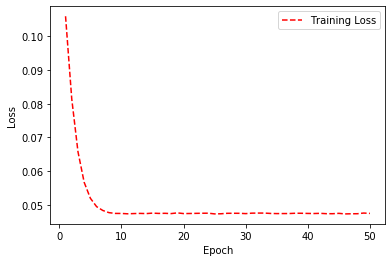

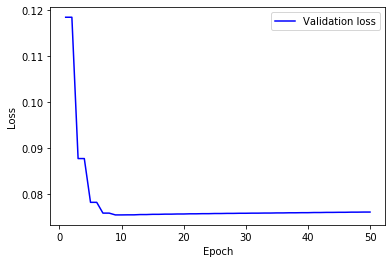

In [30]:
training(model, 50)

In [31]:
path = "./model_state.pt"
model, optimizer, start_epoch, valid_loss_min = load_checkpoint(path, model, optimizer)
print("model = ", model)
print("optimizer = ", optimizer)
print("start_epoch = ", start_epoch)
print("valid_loss_min = ", valid_loss_min)
print("valid_loss_min = {:.6f}".format(valid_loss_min))

model =  LSTM(
  (lstm): LSTM(5, 12, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=12, out_features=1, bias=True)
)
optimizer =  AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0.01
)
start_epoch =  10
valid_loss_min =  0.075432852239729
valid_loss_min = 0.075433


In [0]:
testing_states = model.init_hidden_states()
predictions = []
for idx, (x_batch, _) in enumerate(testing_dl):
  with torch.no_grad():
    x_batch = x_batch.float().to(device)
    testing_states = [state.detach() for state in testing_states]
    output, testing_states = model(x_batch, testing_states)
    predictions.append(output[:, -1, :])

In [33]:
len(predictions)

55

In [35]:
predictions[-1]

tensor([[ 0.0052],
        [ 0.0032],
        [-0.0028],
        [-0.0086],
        [-0.0054]], device='cuda:0')

ValueError: ignored

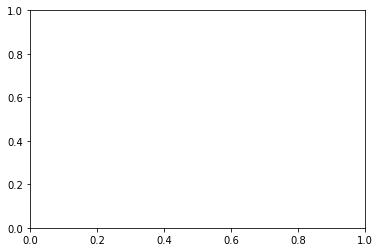

In [34]:
epoch_count = range(1, len(predictions) + 1)
plt.plot(epoch_count, predictions, 'r--')
plt.legend(['Predictions'])
plt.xlabel('Epoch')
plt.ylabel('Prediction')
plt.show()

In [0]:
state_dim = (NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE)

def make_predictions(input, num_predictions):
    model.eval()
    predictions = []
    for i in range(num_predictions):
        with torch.no_grad():


        
          states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
          predictions.append(model(input, states).item())
  return predictions

In [0]:
# note: batch normalization instead of general normalization

# Make 1 prediction

test_window = test_data[:SEQ_LENGTH]
test_tensor = torch.tensor(test_window.values).float()
test_batch = test_tensor.view(1, SEQ_LENGTH).to(device)
make_predictions(test_tensor, 1)

In [0]:
torch.from_numpy(testing_data.iloc[50][["dormancy", "velocity", "nvts", "sopr", "mvrv"]].values).float()

tensor([ 6.3115,  0.0595, 10.0556,  1.0050,  1.8457])

In [0]:
# https://github.com/jaungiers/LSTM-Neural-Network-for-Time-Series-Prediction

def predict_sequences_multiple(model, data, window_size, prediction_len):
  prediction_seqs = []
  for i in range(int(len(data)/prediction_len)):
    curr_frame = data[i*prediction_len]
    predicted = []
    with torch.no_grad():
      for j in range(prediction_len):
        predicted.append(model(curr_frame[newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-2], predicted[-1], axis=0)
      prediction_seqs.append(predicted)
  return prediction_seqs

In [0]:
predict_sequences_multiple(model, testing_data, SEQ_LENGTH, 50)

KeyError: ignored

In [0]:
model.eval()

state_dim = (NUM_LAYERS * DIRECTIONS, BATCH_SIZE, HIDDEN_SIZE)
validation_states = (torch.zeros(state_dim).to(device), torch.zeros(state_dim).to(device))
running_validation_loss = 0.0

predictions = []
with torch.no_grad():
    for idx, (x_batch, y_batch) in enumerate(tqdm(validation_dl)):

        # Convert to Tensors
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.float().to(device)
      
        validation_states = [state.detach() for state in validation_states]
        
        output, validation_states = model(x_batch, validation_states)
        import pdb; pdb.set_trace()
        predictions.append(output[:, -1, :])

  0%|          | 0/436 [00:00<?, ?it/s]

> <ipython-input-34-d802e7a2c1a9>(19)<module>()
-> predictions.append(output[:, -1, :])
(Pdb) output
tensor([[[0.0241],
         [0.0118],
         [0.0052],
         [0.0018],
         [0.0011],
         [0.0009],
         [0.0014],
         [0.0029],
         [0.0034],
         [0.0047],
         [0.0054],
         [0.0050],
         [0.0044],
         [0.0041],
         [0.0043],
         [0.0040],
         [0.0038],
         [0.0037],
         [0.0040],
         [0.0039],
         [0.0040],
         [0.0046],
         [0.0049],
         [0.0047],
         [0.0045],
         [0.0041],
         [0.0038],
         [0.0038],
         [0.0036],
         [0.0036],
         [0.0036],
         [0.0035],
         [0.0037],
         [0.0036],
         [0.0035],
         [0.0036],
         [0.0039],
         [0.0038],
         [0.0037],
         [0.0036],
         [0.0035],
         [0.0037],
         [0.0036],
         [0.0036],
         [0.0035],
         [0.0039],
         [0.0040],
      

BdbQuit: ignored

ValueError: ignored

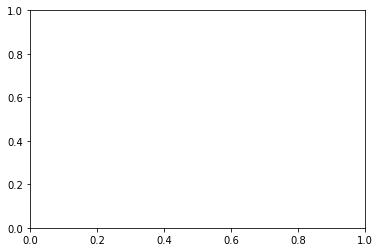

In [0]:
preds_epoch_count = range(1, len(predictions) + 1)
plt.plot(preds_epoch_count, predictions, 'b-')
plt.legend(['Predictions'])
plt.xlabel('Epoch')
plt.ylabel('Predictions')
plt.show()